In [1]:
import sys
sys.path.insert(0, '/mnt/home/raheppt1/projects/MedicalDataAugmentationTool')
sys.path.insert(0, '/mnt/home/raheppt1/projects/age_prediction')
sys.path.insert(0, '/mnt/home/raheppt1/projects/intensity-normalization/')

In [2]:
from pathlib import Path
import numpy as np
import SimpleITK as sitk
import nibabel as nib
import matplotlib.pyplot as plt

In [3]:
data_dir = Path('/mnt/share/raheppt1/project_data/brain/IXI/IXI_T1')
raw_data_dir = data_dir.joinpath('RAW_IXIT1')
pp_data_dir = data_dir.joinpath('W_IXIT1')
subject = '131'
raw_nii = raw_data_dir.joinpath(f'IXI{subject}_T1.nii.gz')
pp_nii = pp_data_dir.joinpath(f'IXI{subject}_T1.nii.gz')
pp_img = sitk.ReadImage(str(pp_nii))
raw_img = sitk.ReadImage(str(raw_nii))

In [4]:
print(f'Raw image: Size {raw_img.GetSize()} Spacing {raw_img.GetSpacing()}')
print(f'Processed image: Size {pp_img.GetSize()} Spacing {pp_img.GetSpacing()}')


Raw image: Size (256, 256, 150) Spacing (0.9375, 0.9375, 1.1999986171722412)
Processed image: Size (105, 127, 105) Spacing (1.5, 1.5, 1.5)


In [5]:
def vis_brain(image, slice_sel, axis_sel=1, normalize=False):
    if normalize:
        image = (image - np.mean(image))/(np.std(image))

    if axis_sel == 1:
        image = image.transpose([1, 2 , 0])
    elif axis_sel == 2:
        image = image.transpose([2, 0, 1])
    
    fig = plt.figure(figsize=(7., 7.))
    plt.imshow(image[slice_sel, : , :], cmap='gray')
    plt.axis('off')
    plt.show()

# Raw-dataset
(B-homogenization is already included for ADNI, but not for IXI)

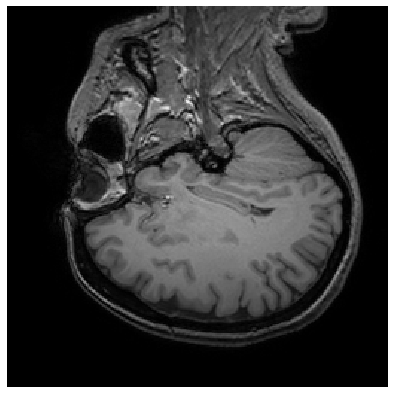

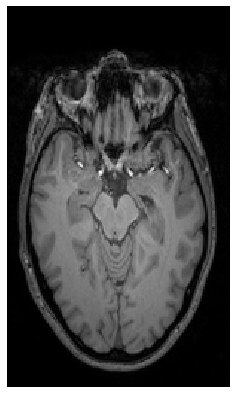

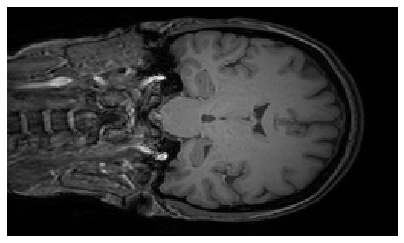

In [6]:
vis_brain(sitk.GetArrayFromImage(raw_img), axis_sel=0, slice_sel = 100)
vis_brain(sitk.GetArrayFromImage(raw_img), axis_sel=1, slice_sel = 130)
vis_brain(sitk.GetArrayFromImage(raw_img), axis_sel=2, slice_sel = 130)

# (old) Preprocessed dataset (spatial MNI normalization)
non-rigid registration / 1.5mm resolution

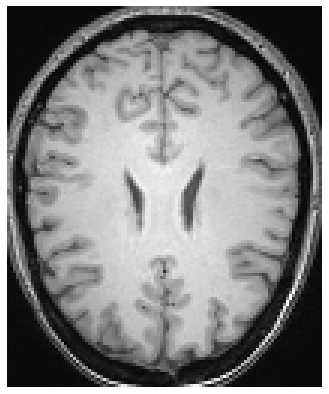

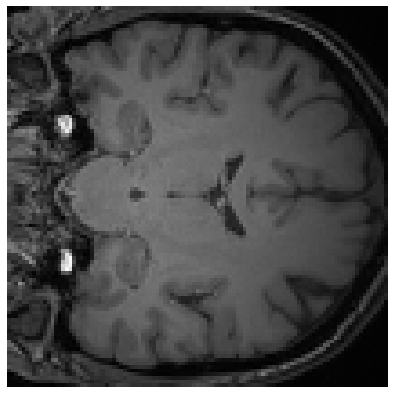

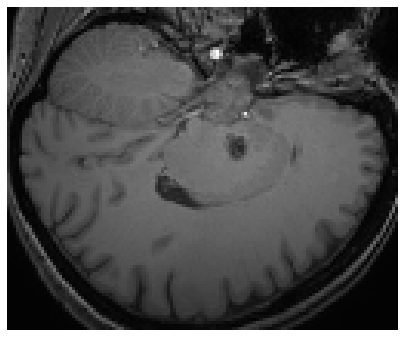

In [7]:
vis_brain(sitk.GetArrayFromImage(pp_img), axis_sel=0, slice_sel = 63)
vis_brain(sitk.GetArrayFromImage(pp_img), axis_sel=1, slice_sel = 63)
vis_brain(sitk.GetArrayFromImage(pp_img), axis_sel=2, slice_sel = 63)

# New Preprocessing

In [17]:
raw_data_sel = '/mnt/share/raheppt1/project_data/brain/IXI/IXI_T1/PP_IXIT1/'
#tmp_data = '/mnt/share/raheppt1/project_data/brain/IXI/IXI_T1/tmp2/'

## Orientation
Apply **RAS** (right-> left, anterior->posterior, superior -> inferior) orientation to all images.

In [18]:
def apply_orientation(path):
    img = nib.load(str(path))
    affine = img.affine
    axcodes = nib.aff2axcodes(affine)
    print(path, axcodes)
    #canonical_img = nib.as_closest_canonical(img)
    #canonical_img.to_filename(str(path))

/mnt/share/raheppt1/project_data/brain/IXI/IXI_T1/PP_IXIT1/IXI002_T1.nii.gz ('R', 'A', 'S')


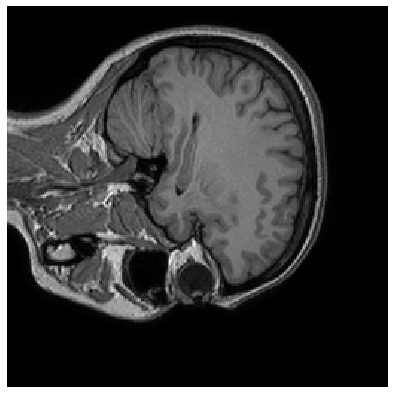

In [19]:
for path in Path(raw_data_sel).glob('**/*_T1.nii*'):
    apply_orientation(path)
    break

for path in Path(raw_data_sel).glob('**/*_T1.nii*'):
    img = nib.load(str(path))
    vis_brain(img.get_fdata(), axis_sel=0, slice_sel=100)
    break

## MNI-Template (152-1mm) 

Orientation: ('R', 'A', 'S')


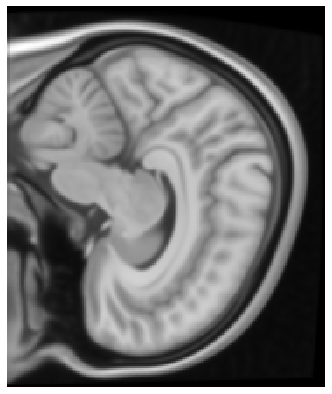

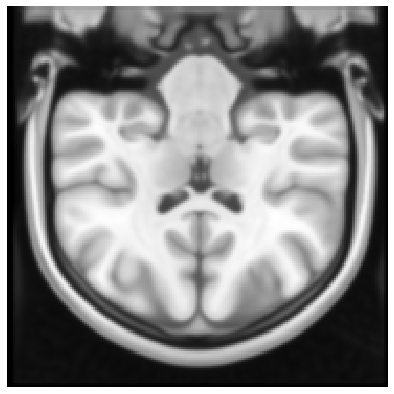

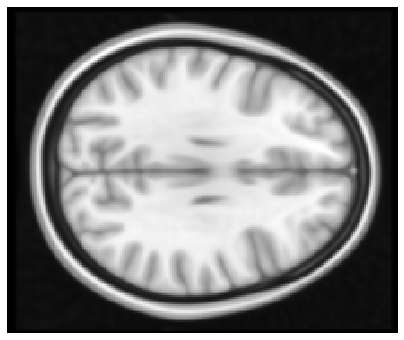

In [8]:
mni_152_1mm_path = '/mnt/share/raheppt1/project_data/brain/MNI152_T1_1mm.nii.gz'
nib_mni_152_1mm = nib.load(str(mni_152_1mm_path))
affine = nib_mni_152_1mm.affine
axcodes = nib.aff2axcodes(affine)
print('Orientation:', axcodes)
vis_brain(nib_mni_152_1mm.get_fdata(), axis_sel=0, slice_sel=100)
vis_brain(nib_mni_152_1mm.get_fdata(), axis_sel=1, slice_sel=100)
vis_brain(nib_mni_152_1mm.get_fdata(), axis_sel=2, slice_sel=100)

### Spatial normalization with fsl-FLIRT

Using fsl-FLIRT for **rigid** registration with the MNI152-1mm template as reference (6 degrees of freedom):

    fsl5.0-flirt -in IXI012_T1.nii.gz -ref MNI152_T1_1mm.nii.gz  -out reg/IXI012_T1.nii.gz -omat invol2refvol.mat -dof 6

/mnt/share/raheppt1/project_data/brain/IXI/IXI_T1/PP_IXIT1/mni_IXI016_T1.nii.gz


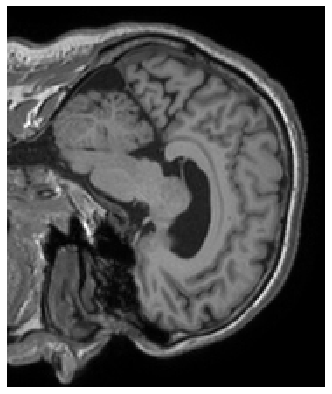

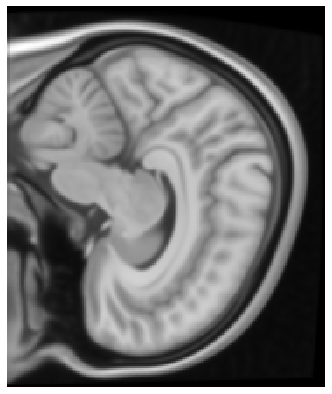

In [23]:
# Plot example and template.
for path in Path(raw_data_sel).glob('**/mni*_T1.nii*'):
    print(path)
    img = nib.load(str(path))
    vis_brain(img.get_fdata(), axis_sel=0, slice_sel=100)
    vis_brain(nib_mni_152_1mm.get_fdata(), axis_sel=0, slice_sel=100)
    break

### Brain segmentation with fsl-bet
The segmentation doesn't use the MNI template!

    fsl5.0-bet IXI012_T1.nii.gz IXI012_T1_brain.nii.gz -m

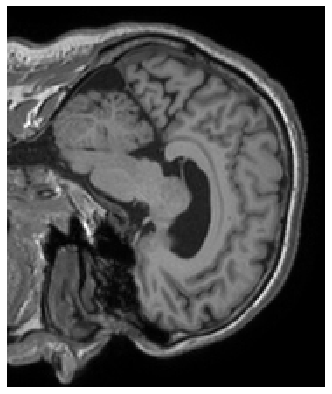

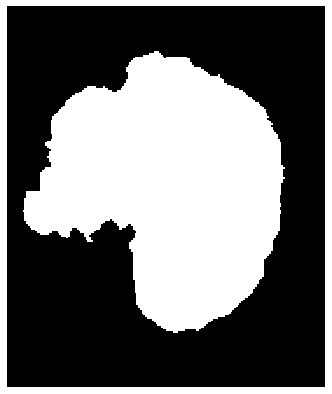

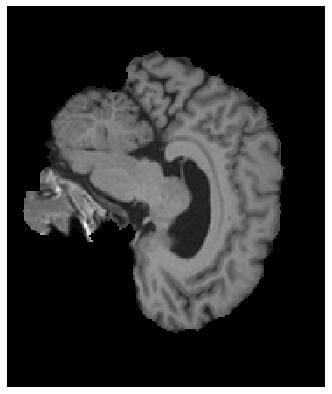

In [33]:
for path in Path(raw_data_sel).glob('**/mni*_T1.nii*'):
    img_reg = nib.load(str(path))
    img_reg_brain = nib.load(str(path.parent.joinpath(path.name.replace('mni', 'brain_mni'))))
    img_reg_brainmask = nib.load(str(path.parent.joinpath(path.name.replace('mni', 'brain_mni').replace('.nii.gz', '_mask.nii.gz'))))
    vis_brain(img_reg.get_fdata(), axis_sel=0, slice_sel=100)
    vis_brain(img_reg_brainmask.get_fdata(), axis_sel=0, slice_sel=100)
    vis_brain(img_reg_brain.get_fdata(), axis_sel=0, slice_sel=100)
    break

# Homogenization

Using fsl-fast for the Bias-Field correction (-B) and simultaneously to create segmentation masks for numerous tissue types (GM, WM, ...).

    fsl5.0-fast -B IXI012_T1_brain.nii.gz

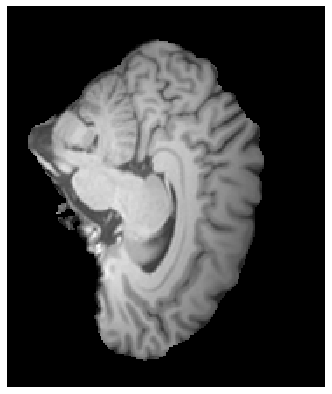

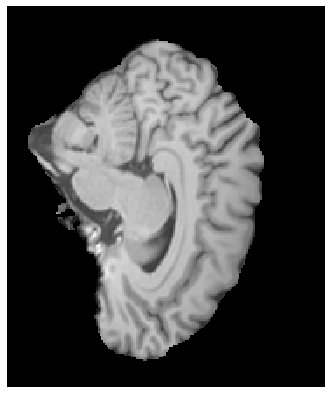

In [36]:
reg_dir = Path(raw_data_sel)
    
img_reg_brain = nib.load(str(reg_dir.joinpath('brain_mni_IXI012_T1.nii.gz')))
img_reg_brainmask = nib.load(str(reg_dir.joinpath('brain_mni_IXI012_T1_restore.nii.gz')))

vis_brain(img_reg_brain.get_fdata(), axis_sel=0, slice_sel=100)
vis_brain(img_reg_brainmask.get_fdata(), axis_sel=0, slice_sel=100)

# Signalintensity normalization

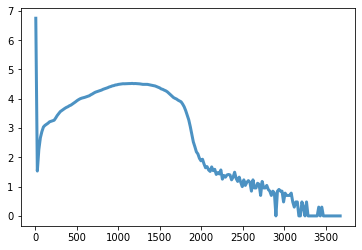

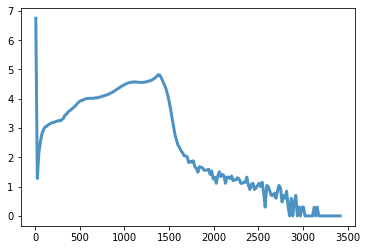

In [37]:
import intensity_normalization

img_reg = nib.load(str(reg_dir.joinpath('brain_mni_IXI012_T1.nii.gz')))
img_reg_brain_biascorr = nib.load(str(reg_dir.joinpath('brain_mni_IXI012_T1_restore.nii.gz')))

# Intensity histograms

# registered image / with homogenization 
intensity_normalization.plot.hist.hist(img_reg)
# registered image - brain only / without homogenization 
intensity_normalization.plot.hist.hist(img_reg_brain_biascorr)

### Per-subject Z-normalisation (using the brain mask!)

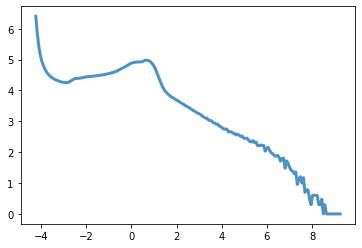

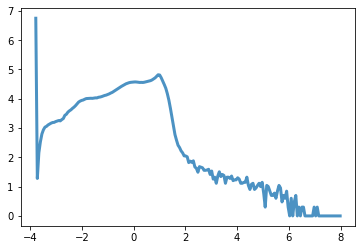

In [257]:
from intensity_normalization.normalize import zscore

# registered image / with homogenization 
img_reg_normalized = zscore.zscore_normalize(img_reg, mask=img_reg_brainmask)
intensity_normalization.plot.hist.hist(img_reg_normalized)

# brain only / with homogenization
img_reg_brain_normalized = zscore.zscore_normalize(img_reg_brain, mask=img_reg_brainmask)
intensity_normalization.plot.hist.hist(img_reg_brain_normalized)

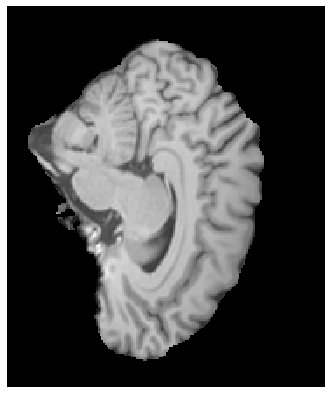

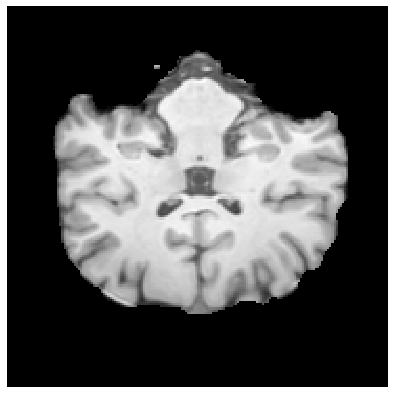

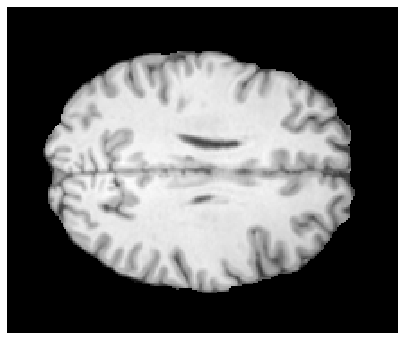

In [259]:
vis_brain(img_reg_brain.get_fdata(), axis_sel=0, slice_sel=100)
vis_brain(img_reg_brain.get_fdata(), axis_sel=1, slice_sel=100)
vis_brain(img_reg_brain.get_fdata(), axis_sel=2, slice_sel=100)

### Per subject FCM normalization

In [ ]:
from intensity_normalization.normalize import fcm

# segmenting white matter with Fuzzy-C means
wm_mask = fcm.find_wm_mask(img_reg, img_reg_brainmask, threshold=0.8)
# Normalizing the brain tissue inside the wm_mask.
normalized_img = fcm.fcm_normalize(img_reg, wm_mask, norm_value=1)
    
intensity_normalization.plot.hist.hist(normalized_img)
